In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from rich.pretty import pprint

from omnivault.transformer.core.dataset import construct_dummy_batch_future_masks
from omnivault.transformer.modules.attention.core import MultiHeadedAttention, ScaledDotProductAttention
from omnivault.transformer.utils.reproducibility import seed_all

## Test Scaled Dot-Product Attention QKV Same Size
 
1. The output shapes of the context vector and attention weights are as expected.
2. The attention weights across the sequence sum up to 1 for each head in each batch, adhering to the properties of a softmax distribution.
3. Each attention weight is within the range [0, 1], which is necessary since they are probabilities.

In [7]:
seed_all(42)

B, H, L, D = 4, 8, 32, 512  # batch size, head, context length, embedding dimension
Q = torch.rand(B, H, L, D)  # query
K = torch.rand(B, H, L, D)  # key
V = torch.rand(B, H, L, D)  # value

# Scaled Dot-Product Attention
attention = ScaledDotProductAttention(dropout=0.0)
context_vector, attention_weights = attention(Q, K, V)

assert context_vector.shape == (B, H, L, D)
assert attention_weights.shape == (B, H, L, L)
pprint(context_vector.shape)
pprint(attention_weights.shape)

# assert each row of attention_weights sums to 1
# assert each element of attention_weights is between 0 and 1
attention_weights_summed_over_sequences = attention_weights.sum(dim=-1)
assert torch.allclose(
    attention_weights_summed_over_sequences, torch.ones(B, H, L)
), "The attention weights distribution induced by softmax should sum to 1."
assert torch.all(
    (0 <= attention_weights) & (attention_weights <= 1)
), "All attention weights should be between 0 and 1."

/Users/gaohn/gaohn/omniverse/omnivault/transformer/utils/reproducibility.py:69: UserWarning: Deterministic mode is activated. This will negatively impact performance and may cause increase in CUDA memory footprint.
  configure_deterministic_mode()


torch.Size([4, 8, 32, 512])

torch.Size([4, 8, 32, 32])

## Test Scaled Dot-Product Attention QKV Different Size

In [8]:
seed_all(42)
B, H, S, T, D = 4, 8, 40, 32, 512  # batch size, head, source length, target length, embedding dimension

Q = torch.rand(B, H, T, D)  # query
K = torch.rand(B, H, S, D)  # key
V = torch.rand(B, H, S, D)  # value

attention = ScaledDotProductAttention(dropout=0.0)
context_vector, attention_weights = attention(Q, K, V)
assert context_vector.shape == (B, H, T, D)
assert attention_weights.shape == (
    B,
    H,
    T,
    S,
)  # Because each query in T attensds to all keys in S, which is why the last dimension of attention_weights is S, representing the sequence length of Key.
# assert each row of attention_weights sums to 1
# assert each element of attention_weights is between 0 and 1
attention_weights_summed_over_sequences = attention_weights.sum(dim=-1)
assert torch.allclose(
    attention_weights_summed_over_sequences, torch.ones(B, H, T)
), "The attention weights distribution induced by softmax should sum to 1."
assert torch.all(
    (0 <= attention_weights) & (attention_weights <= 1)
), "All attention weights should be between 0 and 1."


## MHA Layer Test

In [ ]:

seed_all(42)

B, H, L, D = 4, 8, 32, 512  # batch size, head, context length, embedding dimension
dropout, bias = 0.0, False
attention = ScaledDotProductAttention(dropout=0.0)

mha = MultiHeadedAttention(attention=attention, H=H, d_model=D, dropout=dropout, bias=bias)

# test self attention shape without mask
z = torch.rand(B, L, D)
output = mha(query=z, key=z, value=z, mask = None)
assert output.shape == (B, L, D)
pprint(output.shape)

## MHA Future Masking

torch.Size([4, 32, 512])

tensor([[[[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.4687, 0.5313, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.3325, 0.3532, 0.3143,  ..., 0.0000, 0.0000, 0.0000],
│   │     ...,
│   │     [0.1232, 0.1312, 0.1170,  ..., 0.1323, 0.0000, 0.0000],
│   │     [0.1077, 0.1175, 0.1051,  ..., 0.1193, 0.1145, 0.0000],
│   │     [0.0939, 0.1053, 0.0955,  ..., 0.1028, 0.1054, 0.0997]],
│   │    
│   │    [[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.4917, 0.5083, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.3214, 0.3415, 0.3371,  ..., 0.0000, 0.0000, 0.0000],
│   │     ...,
│   │     [0.1199, 0.1303, 0.1276,  ..., 0.1220, 0.0000, 0.0000],
│   │     [0.1074, 0.1177, 0.1174,  ..., 0.1033, 0.1031, 0.0000],
│   │     [0.0932, 0.1080, 0.1033,  ..., 0.0913, 0.0968, 0.0975]],
│   │    
│   │    [[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.5023, 0.4977, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.3383, 0.3238, 0.3379,  ..., 0.0000, 0.0000, 0.0000],
│   │     ...,
│   │     [0.1255, 0.1242, 0.1302,  ..., 0.1315, 0.0000, 0.0000],
│   │     [0.1105, 0.1122, 0.1099,  ..., 0.1088, 0.1297, 0.0000],
│   │     [0.1003, 0.0984, 0.1005,  ..., 0.0979, 0.1125, 0.1019]],
│   │    
│   │    [[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.5259, 0.4741, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.3473, 0.3270, 0.3257,  ..., 0.0000, 0.0000, 0.0000],
│   │     ...,
│   │     [0.1375, 0.1217, 0.1184,  ..., 0.1276, 0.0000, 0.0000],
│   │     [0.1131, 0.1088, 0.1044,  ..., 0.1195, 0.1214, 0.0000],
│   │     [0.1090, 0.0967, 0.0946,  ..., 0.1022, 0.1010, 0.1072]]],
│   │   
│   │   
│   │   [[[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.5226, 0.4774, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.3431, 0.3148, 0.3421,  ..., 0.0000, 0.0000, 0.0000],
│   │     ...,
│   │     [0.1225, 0.1206, 0.1278,  ..., 0.1185, 0.0000, 0.0000],
│   │     [0.1118, 0.0984, 0.1098,  ..., 0.1090, 0.1235, 0.0000],
│   │     [0.1051, 0.0923, 0.1028,  ..., 0.0975, 0.1116, 0.0886]],
│   │    
│   │    [[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.4926, 0.5074, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.3141, 0.3354, 0.3504,  ..., 0.0000, 0.0000, 0.0000],
│   │     ...,
│   │     [0.1157, 0.1300, 0.1319,  ..., 0.1281, 0.0000, 0.0000],
│   │     [0.1085, 0.1204, 0.1182,  ..., 0.1106, 0.1090, 0.0000],
│   │     [0.0944, 0.1036, 0.1067,  ..., 0.0974, 0.0954, 0.1029]],
│   │    
│   │    [[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.4886, 0.5114, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.3238, 0.3371, 0.3391,  ..., 0.0000, 0.0000, 0.0000],
│   │     ...,
│   │     [0.1276, 0.1224, 0.1272,  ..., 0.1185, 0.0000, 0.0000],
│   │     [0.1111, 0.1092, 0.1131,  ..., 0.1110, 0.1174, 0.0000],
│   │     [0.0975, 0.0995, 0.1036,  ..., 0.0947, 0.1029, 0.0987]],
│   │    
│   │    [[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.5019, 0.4981, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.3186, 0.3428, 0.3387,  ..., 0.0000, 0.0000, 0.0000],
│   │     ...,
│   │     [0.1223, 0.1303, 0.1207,  ..., 0.1326, 0.0000, 0.0000],
│   │     [0.1111, 0.1167, 0.1114,  ..., 0.1141, 0.1072, 0.0000],
│   │     [0.1010, 0.1069, 0.1026,  ..., 0.1059, 0.0925, 0.1001]]],
│   │   
│   │   
│   │   [[[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.5313, 0.4687, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.3358, 0.3098, 0.3544,  ..., 0.0000, 0.0000, 0.0000],
│   │     ...,
│   │     [0.1259, 0.1246, 0.1366,  ..., 0.1159, 0.0000, 0.0000],
│   │     [0.1178, 0.1102, 0.1201,  ..., 0.1093, 0.1047, 0.0000],
│   │     [0.1071, 0.0963, 0.1084,  ..., 0.0898, 0.1007, 0.1028]],
│   │    
│   │    [[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.5112, 0.4888, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
│   │     [0.3444, 0.3336, 0.3220,  ..., 0.0000, 0.0

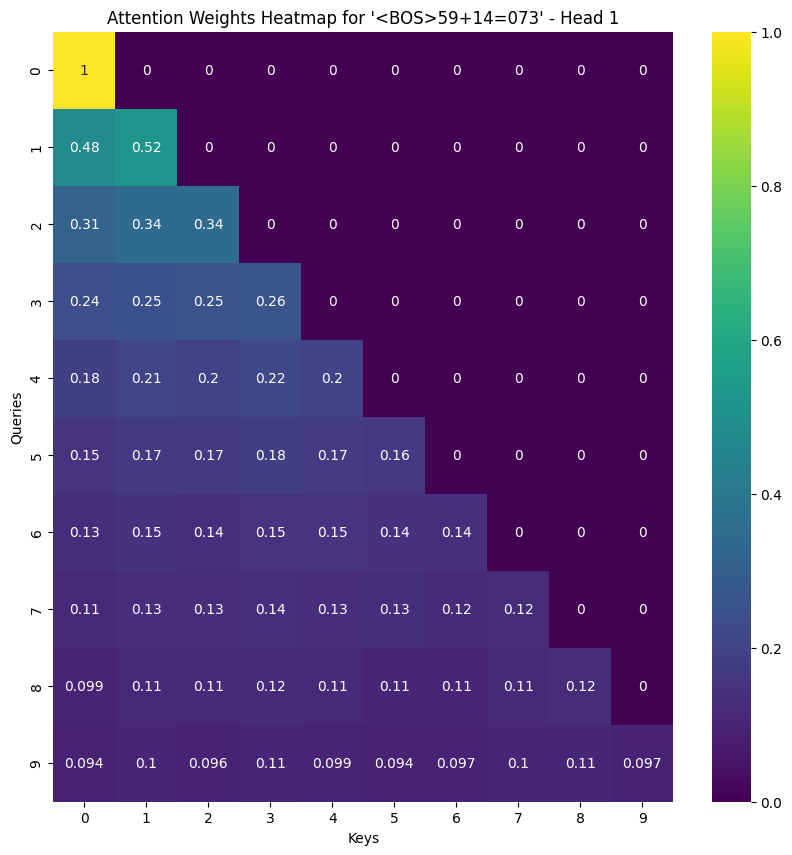

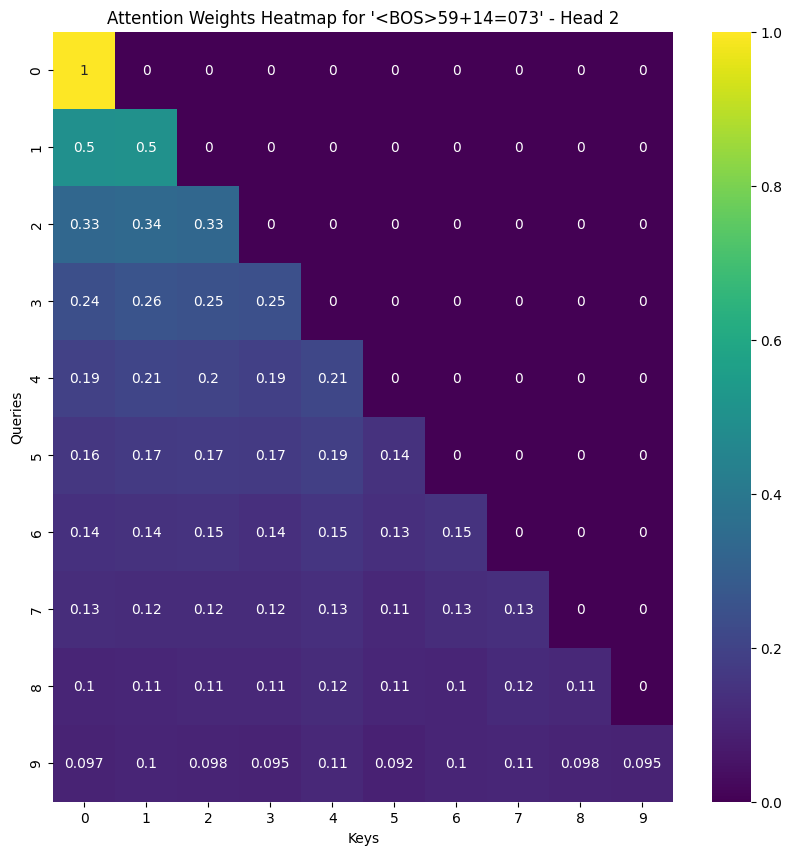

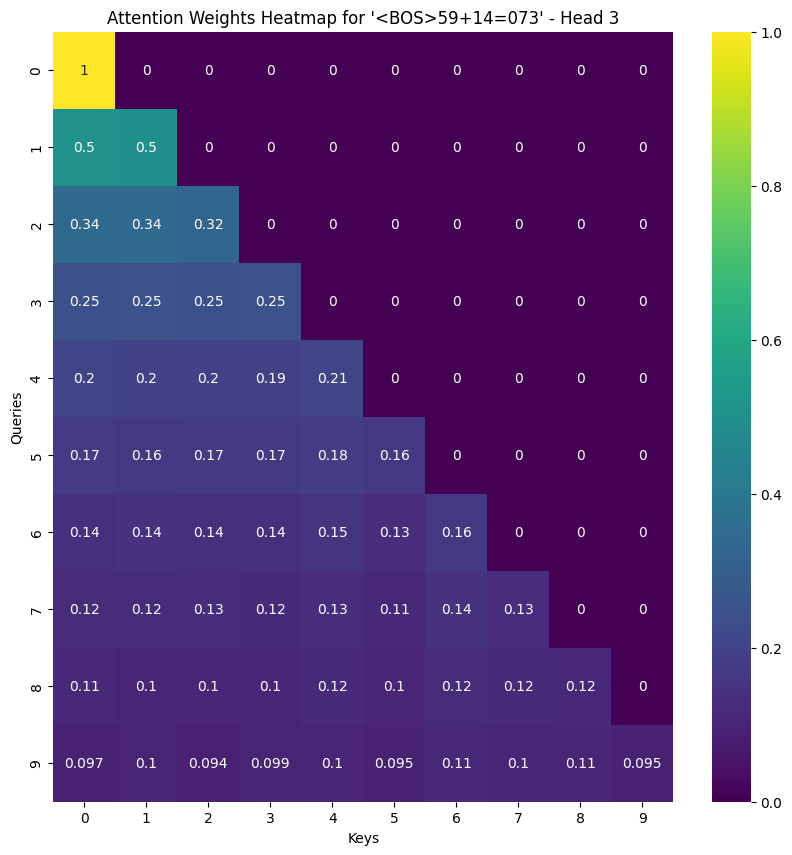

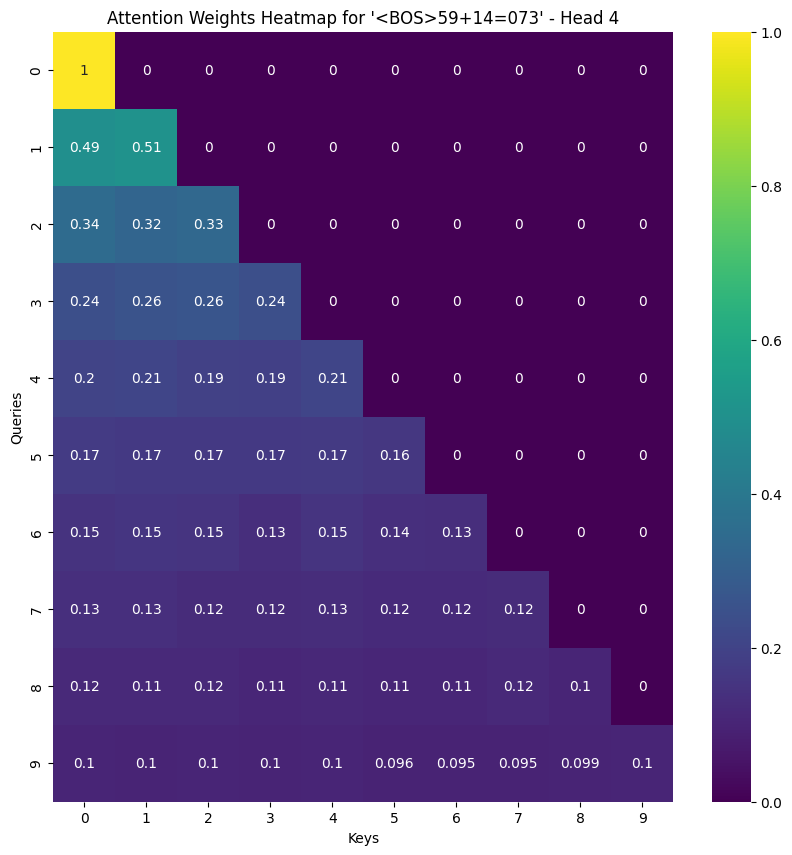

In [9]:
# test self attention shape with future mask
seed_all(42)
B, H, L, D = 4, 4, 10, 512  # batch size, head, context length, embedding dimension

casaul_mha = MultiHeadedAttention(attention=attention, H=H, d_model=D, dropout=dropout, bias=bias)
future_mask = construct_dummy_batch_future_masks(batch_size=B, seq_len=L)
z = torch.rand(B, L, D)
output = casaul_mha(query=z, key=z, value=z, mask = future_mask)
assert output.shape == (B, L, D)
attention_weights = casaul_mha.attention_weights
assert attention_weights.shape == (B, H, L, L)
pprint(attention_weights)

for head in range(H):
    plt.figure(figsize=(10, 10))

    # Extract attention weights for the last sample in the last batch for this head
    attention_matrix = attention_weights[-1, head, :, :].detach().numpy()

    sns.heatmap(attention_matrix, annot=True, cmap='viridis')
    plt.title(f"Attention Weights Heatmap for '<BOS>59+14=073' - Head {head+1}")
    plt.xlabel("Keys")
    plt.ylabel("Queries")
    plt.show()

## Variance of Scaled Dot-Product Attention

There is a factor of about 512.

When you initialize the query $Q$ and key $K$ matrices with elements from a
normal distribution with a standard deviation $\sigma$ of 1, the variance of
these elements is $\sigma^2$, which is also 1 since $\sigma = 1$.

Now, when you compute the dot product $Q \cdot K^T$ for a single pair of vectors
$q$ and $k$, you sum up $d_k$ products of pairs of normally distributed
variables. If these variables were independent, the variance of the sum would
indeed be $d_k \times \sigma^2$, because variances of independent variables add
up.

In your case, since $\sigma^2 = 1$, the variance of the sum before scaling is
expected to be $d_k \times \sigma^2 = d_k \times 1 = d_k$, which is 512 for
$d_k = 512$. This is why the unscaled variance is approximately 512 times larger
than the scaled variance.

The scaling factor $\frac{1}{\sqrt{d_k}}$ is then used to scale down the summed
variances back to $\sigma^2$, which is 1. This is done by dividing the dot
product by $\sqrt{d_k}$, which reduces the variance of the sum by a factor of
$d_k$ because when scaling a random variable by a constant, the variance is
scaled by the square of that constant.

In summary, yes, the factor of 512 in the unscaled variance is normal and
directly corresponds to the dimensionality $d_k$ of the key/query vectors in the
attention mechanism. The scaling factor is applied to control this variance and
maintain the stability of the gradients during training.

In [11]:
seed_all(92)  # 6

# Set the dimensionality of the keys and queries
d_k = 512
# Set the batch size, number of heads, and sequence length
B, H, L = 4, 8, 32
# Standard deviation for initialization
sigma = 1.0

# Initialize Q and K with variance sigma^2
Q = torch.randn(B, H, L, d_k) * sigma
K = torch.randn(B, H, L, d_k) * sigma

# Calculate dot products without scaling
unscaled_dot_products = torch.matmul(Q, K.transpose(-2, -1))

# Calculate the variance of the unscaled dot products
unscaled_variance = unscaled_dot_products.var(unbiased=False)

# Apply the scaling factor 1 / sqrt(d_k)
scaled_dot_products = unscaled_dot_products / torch.sqrt(torch.tensor(d_k).float())

# Calculate the variance of the scaled dot products
scaled_variance = scaled_dot_products.var(unbiased=False)

# Apply softmax to the scaled and unscaled dot products
softmax_unscaled = torch.nn.functional.softmax(unscaled_dot_products, dim=-1)
softmax_scaled = torch.nn.functional.softmax(scaled_dot_products, dim=-1)

# Display the calculated variances
print(f"Unscaled Variance: {unscaled_variance}")
print(f"Scaled Variance: {scaled_variance}")

Unscaled Variance: 512.0117797851562
Scaled Variance: 1.0000230073928833


/Users/gaohn/gaohn/omniverse/omnivault/transformer/utils/reproducibility.py:69: UserWarning: Deterministic mode is activated. This will negatively impact performance and may cause increase in CUDA memory footprint.
  configure_deterministic_mode()


'There is a factor of about 512.\n\nWhen you initialize the query $Q$ and key $K$ matrices with elements from a\nnormal distribution with a standard deviation $\\sigma$ of 1, the variance of\nthese elements is $\\sigma^2$, which is also 1 since $\\sigma = 1$.\n\nNow, when you compute the dot product $Q \\cdot K^T$ for a single pair of vectors\n$q$ and $k$, you sum up $d_k$ products of pairs of normally distributed\nvariables. If these variables were independent, the variance of the sum would\nindeed be $d_k \times \\sigma^2$, because variances of independent variables add\nup.\n\nIn your case, since $\\sigma^2 = 1$, the variance of the sum before scaling is\nexpected to be $d_k \times \\sigma^2 = d_k \times 1 = d_k$, which is 512 for\n$d_k = 512$. This is why the unscaled variance is approximately 512 times larger\nthan the scaled variance.\n\nThe scaling factor $\x0crac{1}{\\sqrt{d_k}}$ is then used to scale down the summed\nvariances back to $\\sigma^2$, which is 1. This is done by d